In [14]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

Import data

In [15]:
pd.options.display.max_rows = 4000
df = pd.read_csv('./AllDataShort.csv')
df.head()

,Date,Price (SP500),Unnamed: 2,Date1,Price (MSCI),Unnamed: 5,Date2,Price (GFD),Unnamed: 8,Date3,Price (GSCI),Unnamed: 11,Date4,Price (NAREIT),Unnamed: 14,Date5,Price (SP500 TR)
0,1/1/72,103.94,NaN,1/1/72,124.25,NaN,1/1/72,6.09,NaN,1/1/72,144.75,NaN,1/1/72,101.22,NaN,1/1/88,257.47
1,2/1/72,106.57,NaN,2/1/72,132.41,NaN,2/1/72,6.04,NaN,2/1/72,144.35,NaN,2/1/72,102.18,NaN,2/1/88,269.48
2,3/1/72,107.20,NaN,3/1/72,136.78,NaN,3/1/72,6.12,NaN,3/1/72,146.26,NaN,3/1/72,102.44,NaN,3/1/88,261.15
3,4/1/72,107.67,NaN,4/1/72,140.06,NaN,4/1/72,6.14,NaN,4/1/72,150.54,NaN,4/1/72,102.70,NaN,4/1/88,264.04
4,5/1/72,109.53,NaN,5/1/72,144.62,NaN,5/1/72,6.05,NaN,5/1/72,154.06,NaN,5/1/72,101.15,NaN,5/1/88,266.32


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              492 non-null    object 
 1   Price (SP500)     492 non-null    float64
 2   Unnamed: 2        0 non-null      float64
 3   Date1             492 non-null    object 
 4   Price (MSCI)      469 non-null    float64
 5   Unnamed: 5        0 non-null      float64
 6   Date2             492 non-null    object 
 7   Price (GFD)       492 non-null    float64
 8   Unnamed: 8        0 non-null      float64
 9   Date3             492 non-null    object 
 10  Price (GSCI)      492 non-null    float64
 11  Unnamed: 11       0 non-null      float64
 12  Date4             492 non-null    object 
 13  Price (NAREIT)    492 non-null    float64
 14  Unnamed: 14       0 non-null      float64
 15  Date5             300 non-null    object 
 16  Price (SP500 TR)  300 non-null    float64
dt

Drop unessential columns

In [17]:
unessential_cols = [
    'Unnamed: 2', 
    'Unnamed: 5', 
    'Unnamed: 8', 
    'Unnamed: 11', 
    'Unnamed: 14',
    'Date1',
    'Date2',
    'Date3',
    'Date4',
    'Date5',
]
df = df.drop(unessential_cols, axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              492 non-null    object 
 1   Price (SP500)     492 non-null    float64
 2   Price (MSCI)      469 non-null    float64
 3   Price (GFD)       492 non-null    float64
 4   Price (GSCI)      492 non-null    float64
 5   Price (NAREIT)    492 non-null    float64
 6   Price (SP500 TR)  300 non-null    float64
dtypes: float64(6), object(1)
memory usage: 27.0+ KB


In [19]:
df.head()

,Date,Price (SP500),Price (MSCI),Price (GFD),Price (GSCI),Price (NAREIT),Price (SP500 TR)
0,1/1/72,103.94,124.25,6.09,144.75,101.22,257.47
1,2/1/72,106.57,132.41,6.04,144.35,102.18,269.48
2,3/1/72,107.20,136.78,6.12,146.26,102.44,261.15
3,4/1/72,107.67,140.06,6.14,150.54,102.70,264.04
4,5/1/72,109.53,144.62,6.05,154.06,101.15,266.32


Trading algorithm

In [28]:
class GTAA(object):

    def __init__(self, df, name, initial_capital=100.0, sma=10):
        assert not df.empty, 'Dataframe is empty'
        self.df = df
        self.name = name
        assert self.name in self.df.columns, "The column is not in the dataframe"
        assert 'Date' in self.df.columns, "There is no date column in the dataframe"

        self.monthly_price = self.df[name]
        self.capital = initial_capital
        self.sma_price = self.df[name].rolling(sma).mean()
        self.log = [] # [{ type: buy or sell, date, price, sma_price, capital }]

    def simulate(self):
        for i in range(9, len(self.monthly_price)):
            # buy if monthly price > sma price and if previous action was sell
            if self.monthly_price[i] > self.sma_price[i] and \
                (len(self.log) == 0 or (len(self.log) > 0 and self.log[-1].get('type') == 'SELL')):

                new_entry = {
                    'type': 'BUY',
                    'date': self.df['Date'][i],
                    'price': self.monthly_price[i],
                    'sma_price': self.sma_price[i],
                    'capital': self.capital,
                }
                self.log.append(new_entry)
            elif self.monthly_price[i] < self.sma_price[i] and \
                (len(self.log) == 0 or (len(self.log) > 0 and self.log[-1].get('type') == 'BUY')):
                
                self.capital = self._compute_capital(self.log[-1].get('price'), self.monthly_price[i])
                new_entry = {
                    'type': 'SELL',
                    'date': self.df['Date'][i],
                    'price': self.monthly_price[i],
                    'sma_price': self.sma_price[i],
                    'capital': self.capital,
                }
                self.log.append(new_entry)

        if self.log[-1].get('type') == 'BUY':
            self.capital = self._compute_capital(self.log[-1].get('price'), self.monthly_price.values[-1])
        for entry in self.log:
            print(entry)
        print('Final Capital: ${:,.2f}'.format(round(self.capital, 2)))

    def graph_prices(self):
        plt.plot(self.df['Date'], self.monthly_price)
        plt.plot(self.df['Date'], self.sma_price)
        plt.show()
    
    def graph_capital(self):
        dates = [entry['date'] for entry in self.log]
        capital = [entry['capital'] for entry in self.log]
        plt.plot(dates, capital)
        plt.show()
                    
    def _compute_capital(self, prev_price, new_price):
        return self.capital * (1 + self._compute_percent_change(prev_price, new_price))
    
    def _compute_percent_change(self, prev_price, new_price):
        return (new_price - prev_price) / prev_price


In [29]:
sp_model = GTAA(df, 'Price (SP500)')
sp_model.simulate()

{'type': 'BUY', 'date': '10/1/72', 'price': 111.58, 'sma_price': 108.266, 'capital': 100.0}
{'type': 'SELL', 'date': '2/1/73', 'price': 111.68, 'sma_price': 111.971, 'capital': 100.0896217960208}
{'type': 'BUY', 'date': '1/1/75', 'price': 76.98, 'sma_price': 76.8, 'capital': 100.0896217960208}
{'type': 'SELL', 'date': '9/1/75', 'price': 83.87, 'sma_price': 84.363, 'capital': 109.04802000561527}
{'type': 'BUY', 'date': '10/1/75', 'price': 89.04, 'sma_price': 86.41099999999999, 'capital': 109.04802000561527}
{'type': 'SELL', 'date': '11/1/76', 'price': 102.1, 'sma_price': 102.51700000000001, 'capital': 125.0427093730157}
{'type': 'BUY', 'date': '12/1/76', 'price': 107.46, 'sma_price': 103.292, 'capital': 125.0427093730157}
{'type': 'SELL', 'date': '1/1/77', 'price': 102.03, 'sma_price': 103.218, 'capital': 118.72424750910844}
{'type': 'BUY', 'date': '4/1/78', 'price': 96.83, 'sma_price': 93.675, 'capital': 118.72424750910844}
{'type': 'SELL', 'date': '10/1/78', 'price': 93.15, 'sma_price

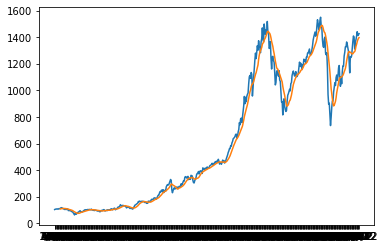

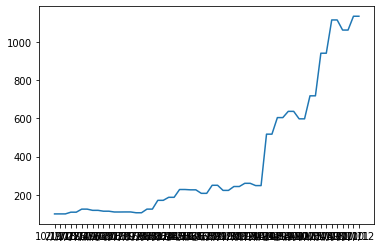

In [30]:
sp_model.graph_prices()
sp_model.graph_capital()